In [3]:
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from collections import Counter
import pandas as pd
import warnings
import json
import os
import plotly.figure_factory as ff
from dash import Dash, dcc, html, callback, Input, Output
import scipy

import plotly.express as px
import chart_studio.plotly as py

# Allow python to import modules from the preprocessing folder
sys.path.append("src/preprocessing/")
warnings.filterwarnings("ignore") # For seaborn

from load_dataset import *

SAVE_PATH = "./data/refined"
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

In [6]:
years = range(1960, 2012)
movies_df = load_movies_df()

In [7]:
movies_df['movie_release_year'] = movies_df[~movies_df['movie_release_date'].isna()]['movie_release_date'].astype(str).str[:4].astype(int)
wrong_dates = movies_df[movies_df['movie_release_year'] < 1800].index
movies_df.loc[wrong_dates]

# A movie that has the release date 1010. We fix the typo to 2010
movies_df.loc[wrong_dates, 'movie_release_year']= 2010
movies_df.loc[wrong_dates, 'movie_release_date'] ='2010-12-02'

In [8]:
groupped = movies_df.groupby("movie_release_year").sum().reset_index()
groupped = groupped.loc[(groupped["movie_release_year"] > 1960) & (groupped["movie_release_year"] < 2012)]

In [9]:
GDP_PATH = "data/gdp/gdp_data.csv"
gdp_df = pd.read_csv(GDP_PATH)

In [10]:
iceland_gdp = gdp_df[gdp_df["Country Name"] == "Iceland"]

gdp_list = []
for year in years:
    gdp_list.append(iceland_gdp[str(year)].iloc[0])
    
iceland_gdp = pd.DataFrame.from_dict({"year" : years, "iceland_gdp" : gdp_list})

In [11]:
groupped = groupped.merge(iceland_gdp, left_on="movie_release_year", right_on="year")
groupped = groupped.rename(columns={"box_office" : "Box-office", "iceland_gdp" : "Iceland GDP"})
groupped = groupped.drop(columns=["wiki_movie_id", "movie_runtime", "movie_release_year"])

In [16]:
melted = pd.melt(groupped, ["year"])
melted = melted.rename(columns={"value" : "Revenue (in $)"})
fig = px.line(melted, x="year", y="Revenue (in $)", color='variable')
fig.update_layout(title_text="Comparison between Iceland GDP and movies' box office each year", title_x=0.5)
fig.write_html('plot/box_office_vs_gdp.html', auto_open=True)

In [17]:
imdb_ratings_df = load_imdb_ratings()

In [18]:
imdb_ratings_df

,tconst,averageRating,numVotes
0,tt0000001,5.7,2004
1,tt0000002,5.8,269
2,tt0000003,6.5,1902
3,tt0000004,5.5,178
4,tt0000005,6.2,2685
...,...,...,...
1365863,tt9916730,7.6,11
1365864,tt9916766,7.0,22
1365865,tt9916778,7.2,36
1365866,tt9916840,8.8,6


In [19]:
fig = px.histogram(imdb_ratings_df, x="averageRating", labels={"averageRating" : "Rating"}, nbins=100)
fig.update_layout(title_text="Distribution of ratings on IMDb", title_x=0.5)
fig.write_html('plot/ratings_histogram.html', auto_open=True)

In [20]:
# ratings_copy = imdb_ratings_df.rename(columns={"numVotes" : "Number of votes"})
fig = px.histogram(imdb_ratings_df, x="numVotes", 
                         labels={"numVotes" : "Number of votes"}, 
                         log_y=True, nbins=100)
fig.update_layout(title_text="Number of movies over number of votes", title_x=0.5)
fig.write_html('plot/movie_votes.html', auto_open=True)

In [47]:
actors_characters = pd.read_json(os.path.join(SAVE_PATH, "characters.json"))
characters_per_actor = actors_characters[['freebase_actor_id', 'freebase_map_id']].groupby(by='freebase_actor_id').count()
fig = px.histogram(characters_per_actor, x='freebase_map_id',
             labels={"freebase_map_id" : "Number of roles", "count" : "Number of actors"},
             log_y=True, nbins=100)
fig.update_layout(title_text="Distribution of actors over their number of roles", title_x=0.5)
fig.write_html('plot/actor_roles.html', auto_open=True)

# plt.yscale('log')
# plt.xlabel("Number of roles")
# plt.ylabel("Number of actors")
# plt.title("Histogram of number of roles per actor")
# plt.show()

## Personas terms

In [28]:
import json
import gensim.downloader
from sklearn.manifold import TSNE

In [22]:
with open("data/cmu/personas/persona_verbs.json") as f:
    frequent_terms = json.load(f)

In [25]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [26]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-50')

In [27]:
# nice_personas = {4, 5, 40, 43}

cluster_points = dict()
word_vectors = []
word_personas = []
word_labels = []

for p in range(1, 51):
    words = frequent_terms[str(p)]

    for w in words:
        word_vectors.append(glove_vectors[w])
        word_personas.append(str(p))
        word_labels.append(w)

In [29]:
tsne = TSNE(n_components=2, learning_rate='auto', random_state=10,
                   init='random', perplexity=3, metric='cosine').fit_transform(np.array(word_vectors))

In [30]:
df = pd.DataFrame.from_dict({'tsne_1' : tsne[:,0], 'tsne_2' : tsne[:,1], 'persona' : word_personas, 'label' : word_labels})

In [44]:
nice_personas = {"14", "5", "27", "40", "43"}

fig = px.scatter(df[df["persona"].isin(nice_personas)], x="tsne_1", y="tsne_2", color="persona",
                 hover_data=['label'],
                labels={"tsne_1" : "Dimension 1 of TSNE", "tsne_2" : "Dimension 2 of TSNE", "persona" : "Persona ID"})

fig.update_layout(title_text="Word2Vec representations (reduced by TSNE) <br> of the most frequent words for some personas", title_x=0.5)
fig.update_traces(marker=dict(size=10))
fig.write_html('plot/persona_scatter.html', auto_open=True)

## MIP genres

In [1]:
def calculate_mip(frequencies, h_prior):
    # Build the posteriori distribution (conditionned on actor)
    h_posteriori = scipy.stats.entropy(frequencies, base=2)

    return (h_prior - h_posteriori) / h_prior

In [4]:
# Load all previous results
movies = pd.read_json(os.path.join(SAVE_PATH, "movies.json"))
movie_genres = pd.read_json(os.path.join(SAVE_PATH, "movie_genres.json"))

actors_characters = pd.read_json(os.path.join(SAVE_PATH, "characters.json"))
actors_characters_personas = pd.read_json(os.path.join(SAVE_PATH, "characters_personas.json"))
actors_characters_personas_genres = pd.read_json(os.path.join(SAVE_PATH, "characters_personas_genres.json"))

actor_movies_with_genre = pd.read_json(os.path.join(SAVE_PATH, "actor_movies_with_genre.json"))

In [5]:
# Retrieve movies for which we have characters
movies_from_characters = actors_characters.wiki_movie_id.unique()
movies_with_characters = movies[movies.wiki_movie_id.isin(movies_from_characters)].reset_index(drop = True).copy()

# Retrieve global genre distribution
all_movie_genres = movies_with_characters["genres"]

# Compute the entropy of movie genres
movie_frequency_genre = dict(Counter(all_movie_genres.explode().to_list()))
movie_genre_prior_h = scipy.stats.entropy(list(movie_frequency_genre.values()), base=2)

In [6]:
actors_characters_personas_genres["mip_genre"] = actors_characters_personas_genres["genres_freq"].apply(lambda genre_freq: calculate_mip(genre_freq, movie_genre_prior_h))

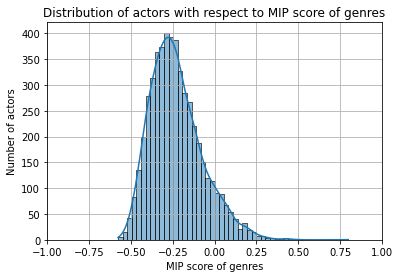

In [7]:
# This parameter allows us to filter out actors that did not play many movies
MINIMUM_NUM_MOVIES_GENRES = 8

sns.histplot(actors_characters_personas_genres.drop_duplicates("freebase_actor_id")[actors_characters_personas_genres["total_movies"] >= MINIMUM_NUM_MOVIES_GENRES], x="mip_genre", bins=50, kde=True)
plt.xlabel("MIP score of genres")
plt.ylabel("Number of actors")
plt.xlim([-1,1])
plt.title("Distribution of actors with respect to MIP score of genres")
plt.grid()
plt.show()

In [8]:
sorted_actor_mip = actors_characters_personas_genres.sort_values("mip_genre").drop_duplicates("freebase_actor_id")[actors_characters_personas_genres["total_movies"] >= MINIMUM_NUM_MOVIES_GENRES][["actor_name", "mip_genre"]]

In [9]:
sorted_actor_mip[-30:]

,actor_name,mip_genre
26762,Stuart Holmes,0.245944
22282,Norma Talmadge,0.248357
19961,Pandari Bai,0.250854
18619,M. G. Ramachandran,0.253150
24887,Meena Kumari,0.258002
21282,Banumathi,0.264378
5735,Maki Horikita,0.272844
18713,Bharat Bhushan,0.274769
16720,Renée Adorée,0.278218
950,Kasinadhuni Viswanath,0.280677


In [74]:
from collections import Counter

def genres_analysis_for_actor(actor_movies_with_genre, movie_genres, actor_name):
    actor_genres = actor_movies_with_genre[actor_movies_with_genre["actor_name"] == actor_name]["movie_genres"]
    
    genres = actor_genres.apply(lambda row : list(row.values())).sum()
    genres_count = Counter(genres)
    
    genres_df = pd.DataFrame.from_dict(data={
        "genre" : list(movie_genres[0]),
        "count" : list(movie_genres.apply(lambda x : genres_count.get(x[0], 0), axis=1))
    })
    
    genres_df = genres_df.sort_values("count", ascending=False)
    genres_df = genres_df[genres_df["count"] > 0]
    
    fig = px.bar(genres_df, x="genre", y="count",
                         labels={"count" : "Number of movies"})    
    fig.show()

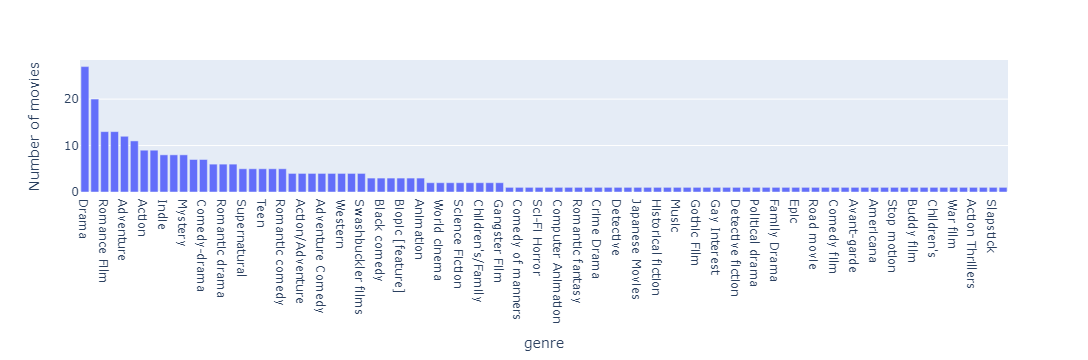

In [75]:
genres_analysis_for_actor(actor_movies_with_genre, movie_genres, "Johnny Depp")

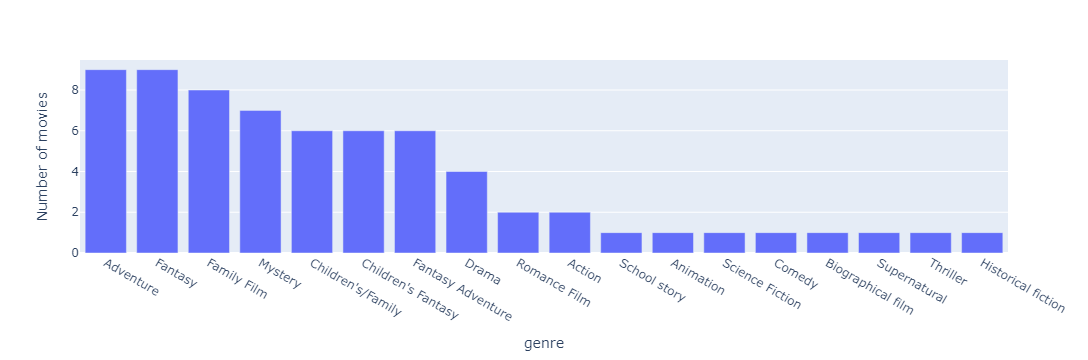

In [76]:
genres_analysis_for_actor(actor_movies_with_genre, movie_genres, "Emma Watson")

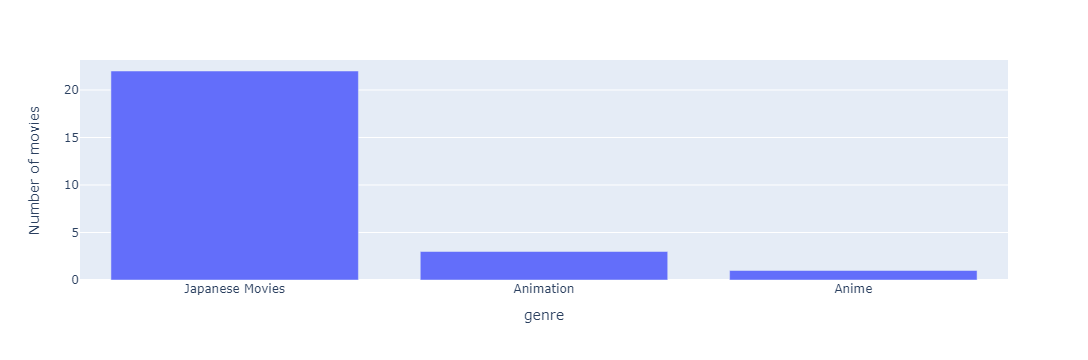

In [77]:
genres_analysis_for_actor(actor_movies_with_genre, movie_genres, "Noriko Ohara")

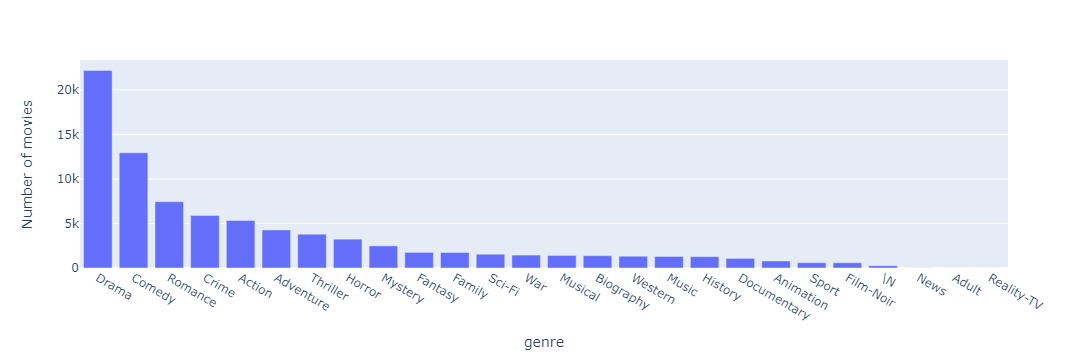

In [80]:
movie_genres_df = pd.DataFrame.from_dict(data={
    "genre" : movie_frequency_genre.keys(),
    "count" : movie_frequency_genre.values()}
)

movie_genres_df = movie_genres_df.sort_values("count", ascending=False)
fig = px.bar(movie_genres_df, x="genre", y="count",
                     labels={"count" : "Number of movies"})    
fig.show()

In [81]:
movie_genres_df

,genre,count
6,Drama,22196
15,Comedy,12946
8,Romance,7448
12,Crime,5909
3,Action,5334
4,Adventure,4277
10,Thriller,3805
13,Horror,3240
17,Mystery,2487
7,Fantasy,1757
